# Implement First

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
sess = tf.Session()
def print_variables(keys):
    i = 0
    print(keys)
    while True:
        try:
            print(tf.get_collection(keys)[i])
            i+=1
        except IndexError:
            break;
def print_tensor(x):
    print(sess.run(x))
def get_shape(tensor):
    return tensor.get_shape().as_list()

# tf.gradients

## 0. Multiple gradients and constant case

In [2]:
w1 = tf.constant([2]) # 1*2
w2 = tf.constant([3]) # 1*2

z1 = w1*w1*w2*w2*w2 # w1^2 w2^3 
z1_w1 = tf.gradients(z1, w1)  # 2w1*w2^3
z1_w1_w1 = tf.gradients(z1_w1, w1)# 2*w2^3
z1_w1_w2 = tf.gradients(z1_w1, w2)# 2w1*3*w2^2
z1_w1_w2_w2 = tf.gradients(z1_w1_w2, w2)# 2w1*6*w2
print_tensor(z1_w1)
print_tensor(z1_w1_w1)
print_tensor(z1_w1_w2)
print_tensor(z1_w1_w2_w2)


[array([108], dtype=int32)]
[array([54], dtype=int32)]
[array([108], dtype=int32)]
[array([72], dtype=int32)]


## 1. variable case and other args

In [3]:
w1 = tf.Variable([2]) # 1*2
w2 = tf.Variable([3]) # 1*2

z1 = w1*w1 + 2*w2 # w1^2 + 2 w2 
z2 = w1 + w2 # w1+w2

grads = tf.gradients(ys = z1, xs = [w1, w2]) # => 2w1, 2
grads2 = tf.gradients(ys = z1, grad_ys = [5], xs = [w1, w2]) # => 5*(2w1, 2)
grads3 = tf.gradients(ys = [z1, z2], grad_ys=[-1, 1], xs = [w1, w2]) # -1*(2w1,-2) + 1*(1, 1) 
sess.run(tf.global_variables_initializer())
print_tensor(grads)
print_tensor(grads2)
print_tensor(grads3)

[array([4], dtype=int32), array([2], dtype=int32)]
[array([20], dtype=int32), array([10], dtype=int32)]
[array([-3], dtype=int32), array([-1], dtype=int32)]


# tf.stop_gradient

In [4]:
a = tf.Variable(1.0)
b = tf.Variable(1.0)

c = a + b

c_stoped = tf.stop_gradient(c)

d = 2*a + 3*b

e = tf.add(c_stoped, d)

gradients = tf.gradients(e, xs=[a, b])

sess.run(tf.global_variables_initializer())

print_tensor(gradients)

[2.0, 3.0]


In [5]:
w1 = tf.Variable(2.0)
w2 = tf.Variable(2.0)
a = w1*3.0 + w2*2.0
a_stopped = tf.stop_gradient(a)

# a_stopped = w1*3.0
# b= a*w2
b = a_stopped + w2

gradients = tf.gradients(xs = tf.trainable_variables()[-2:], ys = b)

train_op = tf.train.RMSPropOptimizer(0.1).apply_gradients(zip(gradients, tf.trainable_variables()[-2:]))

sess.run(tf.global_variables_initializer())
sess.run(train_op)
print(gradients)
print_tensor(gradients[1])
print_tensor([w1, w2])

[None, <tf.Tensor 'gradients_4/add_5_grad/Reshape_1:0' shape=() dtype=float32>]
1.0
[2.0, 1.9]


# tf.get_variable() v.s tf.variable

## 0. Failed example of sharing variable

In [6]:
# Bad example of defining the name of variables
v = tf.Variable(tf.random_normal([2,3]), name='v')
v2 = tf.Variable(tf.random_normal([2,3]), name='v')
x = tf.get_variable('v', [2, 3], initializer= tf.constant_initializer(0.0))

print_variables('trainable_variables')
sess.run(tf.global_variables_initializer())
print_tensor(v)
print_tensor(v2)
print_tensor(x)

trainable_variables
<tf.Variable 'Variable:0' shape=(1,) dtype=int32_ref>
<tf.Variable 'Variable_1:0' shape=(1,) dtype=int32_ref>
<tf.Variable 'Variable_2:0' shape=() dtype=float32_ref>
<tf.Variable 'Variable_3:0' shape=() dtype=float32_ref>
<tf.Variable 'Variable_4:0' shape=() dtype=float32_ref>
<tf.Variable 'Variable_5:0' shape=() dtype=float32_ref>
<tf.Variable 'v:0' shape=(2, 3) dtype=float32_ref>
<tf.Variable 'v_1:0' shape=(2, 3) dtype=float32_ref>
<tf.Variable 'v_2:0' shape=(2, 3) dtype=float32_ref>
[[-0.59384066 -0.70466059 -0.77709585]
 [ 1.00320792 -1.24869776 -0.89308441]]
[[-0.02978455 -1.27130759  0.30037636]
 [ 2.0305264   0.35971001  1.84034228]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]]


## 1. tf.get_varaible => to share variables

In [7]:
with tf.variable_scope('hi') as scope:
    v = tf.get_variable('a', [2,3],initializer= tf.random_normal_initializer())
    scope.reuse_variables()
    x = tf.get_variable('a')
    sess.run(tf.global_variables_initializer())
    print_tensor(v)
    print_tensor(x)
    

[[ 0.42261541  0.16263834  1.64886343]
 [ 1.19830573 -0.6385743  -0.69327295]]
[[ 0.42261541  0.16263834  1.64886343]
 [ 1.19830573 -0.6385743  -0.69327295]]


# tf.control_dependencies

In [8]:
x = tf.Variable([1.])
x_op = tf.assign(x, [2.])
with tf.control_dependencies([x_op]):
    y = tf.add(x, [1.])
sess.run(tf.global_variables_initializer())
print_tensor(y)
print_tensor(x)

[ 3.]
[ 2.]


In [9]:
x = tf.Variable([1.])
x_op = tf.assign(x, [2.])
y = tf.add(x, [1.])
sess.run(tf.global_variables_initializer())
print_tensor(y)
print_tensor(x)
print_tensor(x_op)
print_tensor(x)
print_tensor(y)

[ 2.]
[ 1.]
[ 2.]
[ 2.]
[ 3.]


# tf.train.exponential_decay() and global_step
**decayed_learning_rate** = learning_rate $\times$ decay_rate ^ (global_step / decay_steps)    

* **learning_rate**:  The initial learning rate.  
* **global_step**: Global step to use for the decay computation. Must not be negative.  
* **decay_steps**:  Must be positive. See the decay computation above. 
* **decay_rate**: A scalar float32 or float64 Tensor or a Python number. The decay rate.
* **staircase**: Boolean. It True decay the learning rate at discrete intervals
* **name**: String. Optional name of the operation. Defaults to 'ExponentialDecay'

In [ ]:
x_data = [1., 2., 3.]
y_data = [1., 2., 3.]

w = tf.Variable(tf.random_uniform([1], -1.0, 1.0),name ='w')
b = tf.Variable(tf.random_uniform([1], -1.0, 1.0),name ='b')

hypothesis = w * x_data + b
cost = tf.reduce_mean(tf.square(hypothesis - y_data))
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate= 0.1, global_step= global_step,
                                        decay_steps = 2, decay_rate = 0.96, staircase=True)

#train only w not b
var_list = []
var_list.append(tf.get_collection("trainable_variables")[0])
print("Only train_variable : {}".format(var_list[0]))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss = cost
                                                                  ,global_step=global_step
                                                                 ,var_list = var_list
                                                                  #,var_list = tf.get_collection("trainable_variables")
                                                                 )
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print_tensor(w)
print_tensor(b)
for step in range(10):
    sess.run(train)
    print("i | global_step | learning_rate")
    print("{} |          {}|{}|".format(step, sess.run(global_step), sess.run(learning_rate)))
print_tensor(w)
print_tensor(b)

Only train_variable : <tf.Variable 'w:0' shape=(1,) dtype=float32_ref>
[ 0.26595926]
[-0.73967505]
i | global_step | learning_rate
0 |          1|0.10000000149011612|
i | global_step | learning_rate
1 |          2|0.09600000083446503|
i | global_step | learning_rate
2 |          3|0.09600000083446503|
i | global_step | learning_rate
3 |          4|0.09216000139713287|
i | global_step | learning_rate
4 |          5|0.09216000139713287|
i | global_step | learning_rate
5 |          6|0.0884735956788063|
i | global_step | learning_rate
6 |          7|0.0884735956788063|
i | global_step | learning_rate
7 |          8|0.08493465185165405|
i | global_step | learning_rate
8 |          9|0.08493465185165405|
i | global_step | learning_rate
9 |          10|0.08153726160526276|
[ 1.31700361]
[-0.73967505]


# tf.train.ExponentialMovingAverage
* **semi_weight_track** explaines how shadow variable in ema works

trainable_variables
<tf.Variable 'w:0' shape=() dtype=float32_ref>
<tf.Variable 'b:0' shape=() dtype=float32_ref>
moving_average_variables
ema.average(w) : variable
<tf.Variable 'w/ExponentialMovingAverage:0' shape=() dtype=float32_ref>
ema.average_name(w) : name
w/ExponentialMovingAverage
<class 'dict'>
ema.variables_to_restore() : name to variable
{'w/ExponentialMovingAverage': <tf.Variable 'w:0' shape=() dtype=float32_ref>, 'b/ExponentialMovingAverage': <tf.Variable 'b:0' shape=() dtype=float32_ref>}


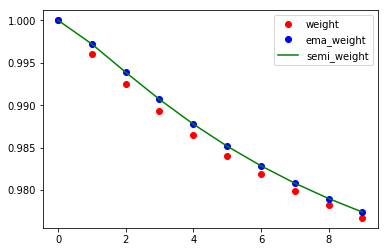

In [2]:
x_data = [1., 2., 3.]
y_data = [1., 2., 3.]

w = tf.Variable(1.0, name ='w')
b = tf.Variable(0.1, name ='b')

hypothesis = w * x_data + b
cost = tf.reduce_mean(tf.square(hypothesis - y_data))
print_variables("trainable_variables")
train = tf.train.GradientDescentOptimizer(0.01).minimize(loss = cost, var_list = [w, b])

decay_rate = 0.3

ema = tf.train.ExponentialMovingAverage(decay = 0.3)

print_variables("moving_average_variables")

with tf.control_dependencies([train]):#after train ema apply
     train_wrapped = ema.apply([w, b])

sess = tf.Session()
sess.run(tf.global_variables_initializer())
    
print("ema.average(w) : variable")
print(ema.average(w))
print("ema.average_name(w) : name")
print(ema.average_name(w))
print(type(ema.variables_to_restore()))
print("ema.variables_to_restore() : name to variable")
print(ema.variables_to_restore())

weight_track = []
ema_weight_track = []
x_axis = []
semi_weight_track = []
for step in range(10):
    weight_track.append(sess.run(w))
    ema_weight_track.append(sess.run(ema.average(w)))# already initialized with weight
    
    if step==0:
        semi_weight_track.append(sess.run(w))
    else:
        semi_weight_track.append(weight_track[-1]*(1-decay_rate) + semi_weight_track[-1]*decay_rate)    
    
    x_axis.append(step)
    sess.run(train_wrapped)

plt.plot(x_axis, weight_track, 'ro',label = 'weight')
plt.plot(x_axis, ema_weight_track, 'bo', label = 'ema_weight')
plt.plot(x_axis, semi_weight_track, 'g', label = 'semi_weight')
plt.legend()
plt.show()

# tf.add

In [3]:
x = tf.constant([1,2])
y = tf.add(x, 1)
print("x")
print_tensor(x)
print("y = tf.add(x, 1)")
print_tensor(y)
print("x+1")
print_tensor(x+1)

x
[1 2]
y = tf.add(x, 1)
[2 3]
x+1
[2 3]


# tf.add_ n

In [52]:
x = tf.constant([1, 2, 3],dtype = tf.float32)
y = tf.constant([4, 5, 6],dtype = tf.float32)
z = tf.constant([7, 8, 9],dtype = tf.float32)
print("x")
print_tensor(x)
print("y")
print_tensor(y)
print("z")
print_tensor(z)
w = tf.add_n([x, y, z])
print("w = tf.add_n([x,y,z])")
print_tensor(w)

x
[ 1.  2.  3.]
y
[ 4.  5.  6.]
z
[ 7.  8.  9.]
w = tf.add_n([x,y,z])
[ 12.  15.  18.]


# tf.scatter_add

In [4]:
x = tf.constant([[1,1,1], [2,2,2], [3,3,3], [4,4,4]], dtype =tf.float32)
y = tf.Variable(tf.zeros(shape=[6, 3], dtype=tf.float32))
sess.run(tf.global_variables_initializer())
print("x")
print_tensor(x)
print("y")
print_tensor(y)
z = tf.scatter_add(ref = y, indices=[4, 0, 1, 1], updates = x)
print("z = tf.scatter_add(ref = y, indices=0, updates = x)")
print_tensor(z)

x
[[ 1.  1.  1.]
 [ 2.  2.  2.]
 [ 3.  3.  3.]
 [ 4.  4.  4.]]
y
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
z = tf.scatter_add(ref = y, indices=0, updates = x)
[[ 2.  2.  2.]
 [ 7.  7.  7.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 0.  0.  0.]]


# tf.matmul v.s. tf.multiply

* **tf.matmul** argument should be (rank2 tensor, rank2 tensor)
* **tf.multipy** only applies to 
1. (same rank tensor, same rank tensor)  
2. ($1\times 1$ tensor, some tensor)

In [5]:
x = tf.constant([[1,1],[1,1]])
y = tf.constant([[1,1],[1,1]])
z1 = tf.multiply(x, y)
z2 = tf.matmul(x, y)
print("x")
print_tensor(x)
print("y")
print_tensor(y)
print("z1 = tf.multiply(x, y)")
print_tensor(z1)
print("z2 = tf.matmul(x, y)")
print_tensor(z2)

x
[[1 1]
 [1 1]]
y
[[1 1]
 [1 1]]
z1 = tf.multiply(x, y)
[[1 1]
 [1 1]]
z2 = tf.matmul(x, y)
[[2 2]
 [2 2]]


# tf.multiply

In [6]:
x = tf.constant([1,3])
y = tf.constant([2,6])
z = tf.multiply(x, y)
w = tf.constant([[1,2],[2,1]])
print("x : {}".format(x.get_shape()))
print_tensor(x)
print("y : {}".format(y.get_shape()))
print_tensor(y)
print("w : {}".format(w.get_shape()))
print_tensor(w)
print("x*y")
print_tensor(x*y)
print("z = tf.multiply(x, y)")
print_tensor(z)
print("tf.multiply([3], x)")
print_tensor(tf.multiply([3], x))
print("tf.multiply(w, x)")
print_tensor(tf.multiply(w,x))
x_r1 = tf.reshape(x, [1,2])
x_r2 = tf.reshape(x, [2,1])
print("x_r1 = tf.reshape(x, [1,2])")
print_tensor(x_r1)
print("x_r2 = tf.reshape(x, [2,1])")
print_tensor(x_r2)
print("w*x_r1")
print_tensor(w*x_r1)
print("w*x_r2")
print_tensor(w*x_r2)

x : (2,)
[1 3]
y : (2,)
[2 6]
w : (2, 2)
[[1 2]
 [2 1]]
x*y
[ 2 18]
z = tf.multiply(x, y)
[ 2 18]
tf.multiply([3], x)
[3 9]
tf.multiply(w, x)
[[1 6]
 [2 3]]
x_r1 = tf.reshape(x, [1,2])
[[1 3]]
x_r2 = tf.reshape(x, [2,1])
[[1]
 [3]]
w*x_r1
[[1 6]
 [2 3]]
w*x_r2
[[1 2]
 [6 3]]


# tf.div

In [7]:
x = tf.constant([1,2,3], dtype = tf.float32)
y = tf.constant([2,4,6], dtype = tf.float32)
z = tf.div(x, y)
print("x")
print_tensor(x)
print("y")
print_tensor(y)
print("x/y")
print_tensor(x/y)
print("z = tf.div(x, y)")
print_tensor(z)
print("tf.div(1., 2.)")
print_tensor(tf.div(1., 2.))

x
[ 1.  2.  3.]
y
[ 2.  4.  6.]
x/y
[ 0.5  0.5  0.5]
z = tf.div(x, y)
[ 0.5  0.5  0.5]
tf.div(1., 2.)
0.5


# tf.exp
안에는 무조건 실수 여야 한다.

In [8]:
print_tensor(tf.exp(1.0))

2.71828


# tf.sqrt

In [9]:
x = tf.constant([1,2,3], dtype = tf.float32)
print("x")
print_tensor(x)
print('tf.sqrt(x)')
print_tensor(tf.sqrt(x))

x
[ 1.  2.  3.]
tf.sqrt(x)
[ 1.          1.41421354  1.73205078]


# tf.one_hot(indices, depth, on_value=None, off_value=None, axis=None, dtype=None, name=None)

* If the location is represented by indices, then the lotcation takes **on_value**, and the other takes **off_value**
* input array rank : $N$ $\Rightarrow$ output array rank : $N+1$
* **Total depth** determines the number of last rank component
> input_shape : $[r_0, r_1, r_2, \cdots r_N]$ changes to 
> ouput_shape : $[r_0, r_1, r_2, \cdots r_N, depth]$

In [10]:
x = tf.constant([[1,3],[3,2]])
x_one_hot = tf.one_hot(indices = x, depth=6, on_value=2.0, off_value=-1.0, dtype='float32')
print("x : {}".format(x.get_shape()))
print_tensor(x)
print("x_one_hot : {}".format(x_one_hot.get_shape()))
print_tensor(x_one_hot)

x : (2, 2)
[[1 3]
 [3 2]]
x_one_hot : (2, 2, 6)
[[[-1.  2. -1. -1. -1. -1.]
  [-1. -1. -1.  2. -1. -1.]]

 [[-1. -1. -1.  2. -1. -1.]
  [-1. -1.  2. -1. -1. -1.]]]


# tf.nn.dropout(x, keep_prob, noise_shape)
* **x** : input
* **keep_prob** : (0,1]
* **noise_shape** : 
> default to be shape(x)  
> if $noise shape[i] == get shape(x)[i]$
=> independent decision  
> ex) $shape(x) = [k, l, m, n], [k, 1, 1, n]$
dim 1, 2 is determined togther
dim 0, 3 is determined independently


In [11]:
x = tf.constant([1., 2., 4., 6.])
print("x")
print_tensor(x)
print("tf.nn.dropout(x, keep_prob = 0.25)")
print_tensor(tf.nn.dropout(x, keep_prob=0.25))
print_tensor(tf.nn.dropout(x, keep_prob=0.25))
print_tensor(tf.nn.dropout(x, keep_prob=0.25))

x
[ 1.  2.  4.  6.]
tf.nn.dropout(x, keep_prob = 0.25)
[  4.   0.   0.  24.]
[  0.   8.   0.  24.]
[ 0.  8.  0.  0.]


In [12]:
x = tf.constant([[[1.,2.,3.],[4.,5.,6.]],[[7.,8.,9.],[10.,11.,12.]]])
print("x : {}".format(x.get_shape()))
print_tensor(x)
print("tf.nn.dropout(x, keep_prob=0.5, noise_shape=[1, 2, 3])")
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[1, 2, 3]))
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[1, 2, 3]))
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[1, 2, 3]))
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[1, 2, 3]))
print("tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 1, 3])")
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 1, 3]))
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 1, 3]))
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 1, 3]))
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 2, 3]))
print("tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 2, 1])")
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 2, 1]))
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 2, 1]))
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 2, 1]))
print_tensor(tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 2, 1]))

x : (2, 2, 3)
[[[  1.   2.   3.]
  [  4.   5.   6.]]

 [[  7.   8.   9.]
  [ 10.  11.  12.]]]
tf.nn.dropout(x, keep_prob=0.5, noise_shape=[1, 2, 3])
[[[  0.   0.   0.]
  [  0.  10.  12.]]

 [[  0.   0.   0.]
  [  0.  22.  24.]]]
[[[  2.   4.   6.]
  [  0.   0.   0.]]

 [[ 14.  16.  18.]
  [  0.   0.   0.]]]
[[[  0.   0.   0.]
  [  8.  10.   0.]]

 [[  0.   0.   0.]
  [ 20.  22.   0.]]]
[[[  2.   4.   0.]
  [  8.  10.  12.]]

 [[ 14.  16.   0.]
  [ 20.  22.  24.]]]
tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 1, 3])
[[[  2.   0.   0.]
  [  8.   0.   0.]]

 [[ 14.   0.  18.]
  [ 20.   0.  24.]]]
[[[  2.   4.   0.]
  [  8.  10.   0.]]

 [[ 14.   0.  18.]
  [ 20.   0.  24.]]]
[[[  0.   0.   6.]
  [  0.   0.  12.]]

 [[ 14.  16.  18.]
  [ 20.  22.  24.]]]
[[[  2.   4.   0.]
  [  8.  10.   0.]]

 [[  0.   0.  18.]
  [  0.  22.   0.]]]
tf.nn.dropout(x, keep_prob=0.5, noise_shape=[2, 2, 1])
[[[  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [ 20.  22.  24.]]]
[[[  2.   4.   6.]
  

# tf.nn.xw_plus_b

In [13]:
x = tf.constant([[1,2]])
w = tf.constant([[3],[1]])
b = tf.constant([1])
# 1*3 + 2*1+1= 6
print_tensor(tf.nn.xw_plus_b(x,w,b))

[[6]]


# tf.nn.embedding_lookup(params, ids)

change ids to params embedding[m, n]  
type of elements in ids should be int(less than m)  
ids are any size of tensor.  
Every elements of ids changes to corresponding params[i]
* See also with **tf.gather**

In [14]:
embedding = tf.Variable(tf.random_uniform([3, 4]))
x = tf.nn.embedding_lookup(embedding, [2, 1, 2, 0])
sess.run(tf.global_variables_initializer())
print("embedding : {}".format(embedding.get_shape()))
print_tensor(embedding)
print("x = tf.nn.embedding_lookup(embedding, [2, 1, 2, 0])")
print_tensor(x)
print("tf.reduce_mean(x)")
print_tensor(tf.reduce_mean(x, axis = 0))

embedding : (3, 4)
[[ 0.57905591  0.63686681  0.31841695  0.27772033]
 [ 0.02685702  0.94557905  0.69220269  0.49113345]
 [ 0.832546    0.88265514  0.96874344  0.10698855]]
x = tf.nn.embedding_lookup(embedding, [2, 1, 2, 0])
[[ 0.832546    0.88265514  0.96874344  0.10698855]
 [ 0.02685702  0.94557905  0.69220269  0.49113345]
 [ 0.832546    0.88265514  0.96874344  0.10698855]
 [ 0.57905591  0.63686681  0.31841695  0.27772033]]
tf.reduce_mean(x)
[ 0.56775123  0.83693904  0.73702669  0.24570772]


In [15]:
embedding1 = tf.Variable([[1,2],[3,4]])
embedding2 = tf.Variable([[5,6],[7,8]])
x = tf.nn.embedding_lookup([embedding1, embedding2], [0,1,2,3,1,2], partition_strategy='mod')
y = tf.nn.embedding_lookup([embedding1, embedding2], [0,1,2,3,1,2], partition_strategy='div')
sess.run(tf.global_variables_initializer())
print_tensor(embedding1)
print_tensor(embedding2)
print_tensor(x)
print_tensor(y)

[[1 2]
 [3 4]]
[[5 6]
 [7 8]]
[[1 2]
 [5 6]
 [3 4]
 [7 8]
 [5 6]
 [3 4]]
[[1 2]
 [3 4]
 [5 6]
 [7 8]
 [3 4]
 [5 6]]


# tf.group

In [16]:
x = tf.Variable(1)
y = tf.Variable(2)
x_op = tf.assign(x, x+1)
y_op = tf.assign(y, y*2)

ops = tf.group(x_op, y_op)
sess.run(tf.global_variables_initializer())
sess.run(ops)

print_tensor(x)
print_tensor(y)

2
4


# tf.reduce_sum

In [17]:
x= [[1, 1, 1], [1, 1, 1]]
print("x")
print(x)
print("tf.reduce_sum(x)")
print_tensor(tf.reduce_sum(x))
print("tf.reduce_sum(x, 0)")
print_tensor(tf.reduce_sum(x, 0))
print("tf.reduce_sum(x, 1)")
print_tensor(tf.reduce_sum(x, 1))
print("tf.reduce_sum(x, [0,1])")
print_tensor(tf.reduce_sum(x, [0,1]))

x
[[1, 1, 1], [1, 1, 1]]
tf.reduce_sum(x)
6
tf.reduce_sum(x, 0)
[2 2 2]
tf.reduce_sum(x, 1)
[3 3]
tf.reduce_sum(x, [0,1])
6


# tf.norm

In [3]:
c = tf.constant([[1,2,3],[-1,-1,1]], dtype = tf.float32)
norm_c = tf.norm(c, axis=1)
print_tensor(c) # sqrt(1*1+2*2+3*3)
print_tensor(norm_c) #sqrt(1+1+1)

[[ 1.  2.  3.]
 [-1. -1.  1.]]
[ 3.7416575   1.73205078]


# tf.cast

In [18]:
x = tf.constant([1.8])
print("x")
print(x.dtype)
y = tf.cast(x, tf.int32)
print("y = tf.cast(x,tf.int32)")
print_tensor(y)
print(y.dtype)
print("x is unchanged")
print(x.dtype)
z = tf.cast(x,'bool')
print("z = tf.cast(x, tf.bool)")
print(z.dtype)

x
<dtype: 'float32'>
y = tf.cast(x,tf.int32)
[1]
<dtype: 'int32'>
x is unchanged
<dtype: 'float32'>
z = tf.cast(x, tf.bool)
<dtype: 'bool'>


# tf.convert_to_tensor

In [19]:
x = [[0.5, 1.5, 0.1],[2.2, 1.3, 1.7]]
print("x : {}".format(type(x)))
print(x)
y = tf.convert_to_tensor(x)
print("y : {}".format(type(y)))
print(y)
print_tensor(y)

x : <class 'list'>
[[0.5, 1.5, 0.1], [2.2, 1.3, 1.7]]
y : <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Const_18:0", shape=(2, 3), dtype=float32)
[[ 0.5         1.5         0.1       ]
 [ 2.20000005  1.29999995  1.70000005]]


# tf.argmax

In [20]:
x = tf.constant([[1,2,3],[2,3,1]])
print("x : {}".format(sess.run(x)))
print("tf.argmax(x,0)")
print_tensor(tf.argmax(x,0))
print("tf.argmax(x,1)")
print_tensor(tf.argmax(x,1))

x : [[1 2 3]
 [2 3 1]]
tf.argmax(x,0)
[1 1 0]
tf.argmax(x,1)
[2 1]


# tf.ones

In [21]:
print_tensor(tf.ones(shape=[3, 2]))

[[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]]


# tf.random_uniform
    default : random_uniform[0 to 1] with the shape
    min_val, max_val to control random_unirom[min_val to 1]

In [22]:
x = tf.random_uniform([2,3])# almost like a constant
print("x : tf.random_uniform([2,3])")
print_tensor(x)
y = tf.random_uniform([2,3],minval=2, maxval=3)
print("y : tf.random_uniform([2,3],minval=2, maxval=3)")
print_tensor(y)
z = tf.Variable(y)
print('tf.get_collection("variables")[-1]')
print(tf.get_collection('variables')[-1])
sess.run(tf.variables_initializer([tf.get_collection('variables')[-1]]))
print("z : tf.Variable(y)")
print_tensor(z)
w = tf.Variable(tf.constant([0,1]))
print(tf.get_collection('variables')[-1])
sess.run(tf.variables_initializer([tf.get_collection('variables')[-1]]))
print_tensor(w)

x : tf.random_uniform([2,3])
[[ 0.24782479  0.75386453  0.28676355]
 [ 0.95951402  0.83935571  0.51980698]]
y : tf.random_uniform([2,3],minval=2, maxval=3)
[[ 2.04688263  2.96229172  2.25560236]
 [ 2.29559135  2.70268464  2.4248538 ]]
tf.get_collection("variables")[-1]
<tf.Variable 'Variable_6:0' shape=(2, 3) dtype=float32_ref>
z : tf.Variable(y)
[[ 2.73688126  2.54293752  2.4212153 ]
 [ 2.2127378   2.96805811  2.76424026]]
<tf.Variable 'Variable_7:0' shape=(2,) dtype=int32_ref>
[0 1]


# tf.sign

In [23]:
x = tf.constant([[-1,2],[3,-4]],dtype = tf.float32)
print("x : tf.constant([[-1,2],[3,-4]],dtype = tf.float32)")
print_tensor(x)
print("tf.sign(x)")
print_tensor(tf.sign(x))
print("(tf.sign(x)+1)/2")
print_tensor((tf.sign(x)+1)/2)

x : tf.constant([[-1,2],[3,-4]],dtype = tf.float32)
[[-1.  2.]
 [ 3. -4.]]
tf.sign(x)
[[-1.  1.]
 [ 1. -1.]]
(tf.sign(x)+1)/2
[[ 0.  1.]
 [ 1.  0.]]


# tf.floor

In [24]:
x = tf.floor([3.3])
y = tf.floor([-3.4])
print("x = tf.floor([3.3])")
print_tensor(x)
print("y = tf.floor([-3.4])")
print_tensor(y)

x = tf.floor([3.3])
[ 3.]
y = tf.floor([-3.4])
[-4.]


# tf.nn.moments

In [25]:
x = tf.constant([[3,4,5],[1,2,4]],dtype = tf.float32)
mean, var = tf.nn.moments(x,[0], name = 'hi')
print(mean)
print(var)
print_tensor(mean)
print_tensor(var)
print_tensor(tf.nn.moments(x,[1],name = 'hi2'))
print_tensor(tf.nn.moments(x,[0,1],name = 'hi2'))

Tensor("hi/Squeeze:0", shape=(3,), dtype=float32)
Tensor("hi/Squeeze_1:0", shape=(3,), dtype=float32)
[ 2.   3.   4.5]
[ 1.    1.    0.25]
(array([ 4.        ,  2.33333325], dtype=float32), array([ 0.66666669,  1.5555557 ], dtype=float32))
(3.1666667, 1.8055555)


# tf.nn.top_k

In [2]:
a = tf.constant([4,9,1,11,2,5,12,10,7,3,8,6], shape=[3,4])
a_v = tf.Variable(a)
sess.run(tf.global_variables_initializer())
print_tensor(a)
print_tensor(-a_v)
values, indices = tf.nn.top_k(-a_v, k=2, sorted=True)
print_tensor(values)
print_tensor(indices)

[[ 4  9  1 11]
 [ 2  5 12 10]
 [ 7  3  8  6]]
[[ -4  -9  -1 -11]
 [ -2  -5 -12 -10]
 [ -7  -3  -8  -6]]
[[-1 -4]
 [-2 -5]
 [-3 -6]]
[[2 0]
 [0 1]
 [1 3]]


# tf.size, tf.rank

In [26]:
x = tf.constant([[1,2],[3,4]])
print_tensor(x)
print("tf.size(x)")
print_tensor(tf.size(x))
print("tf.rank(x)")
print_tensor(tf.rank(x))

[[1 2]
 [3 4]]
tf.size(x)
4
tf.rank(x)
2


# tf.range, tf.size, tf.gather

In [27]:
x = tf.constant([3,4,5,6])
print("x")
print_tensor(x)
print("tf.size(x)")
print_tensor(tf.size(x))
print("tf.range(0, tf.size(x))")
print_tensor(tf.range(0, tf.size(x)))
print("0.5+tf.range(6)/10")
print_tensor(0.2+tf.range(6)/7)
print("tf.gather(x, [1,2,2,1])")
print_tensor(tf.gather(x,[1,2,2,1]))
print("tf.gather(x, [1,3,0])")
print_tensor(tf.gather(x,[1,3,0]))

x
[3 4 5 6]
tf.size(x)
4
tf.range(0, tf.size(x))
[0 1 2 3]
0.5+tf.range(6)/10
[ 0.2         0.34285714  0.48571429  0.62857143  0.77142857  0.91428571]
tf.gather(x, [1,2,2,1])
[4 5 5 4]
tf.gather(x, [1,3,0])
[4 6 3]


# tf.assign(ref, value, validate_shape, use_locking)
    ref : a mutable tensor variable, may be unitialized
    value : a Tensor, same time as ref the value assigned to variable
    validate shape : default true, ture the shape of 'value' matches the shape of the tensor assigned 
                    otherwise shape of 'ref' = shape of 'value'
    

In [28]:
x = tf.Variable([1.], name = 'x')
x_op = tf.assign(x, [2.,3.,4.], validate_shape=False,name= 'tempx')
sess.run(tf.global_variables_initializer())
print_tensor(x_op)
print_tensor(x)

[ 2.  3.  4.]
[ 2.  3.  4.]


# tf.get_default_graph

In [29]:
c = tf.constant(4.0)
print(c.graph)
print(tf.get_default_graph())

# tf.is_inf, tf.is_finite, tf.is_nan
    Must be float in tf.log

In [30]:
print_tensor(tf.is_inf(tf.log(0.0)))
print_tensor(tf.is_inf(tf.log(0.5)))
print_tensor(tf.is_finite(1.0))
print_tensor(tf.is_nan(-tf.log(-1.0)))
print_tensor(tf.is_nan(-tf.log(1.0)))

True
False
True
True
False


# tf.identity

In [32]:
x = tf.constant(2.0)
y = tf.identity(x)
print_tensor(x)
print_tensor(y)

2.0
2.0


# tf.cond

In [33]:
x = tf.constant(2)
y = tf.constant(5)
def f1(): 
    return tf.multiply(x, 17)
def f2(): 
    return tf.add(y, 23)
r = tf.cond(tf.less(x, y), f1, f2)
print(r)
print_tensor(r)

Tensor("cond_2/Merge:0", shape=(), dtype=int32)
34


# tf.clip_by_value()

In [34]:
print_tensor(tf.clip_by_value(0, clip_value_max=5, clip_value_min=3))
print_tensor(tf.clip_by_value(7, clip_value_max=5, clip_value_min=3))
print_tensor(tf.clip_by_value(4, clip_value_max=5, clip_value_min=3))

3
5
4


# tf.nn.conv2d_transpose
* **value** : 
>[batch, height, width, in_channels] for NHWC  
>[batch, in_channels, height, width] for NCHW
* **filter** : [height, width, output_channels, in_channels]
* **output_shape** : output shape of the deconvolution op.
* **strides** : the stride of the sliding window for each dimension of the input tensor.
* **padding** : 'VALID' or 'SAME'
* **data_format** : 'NHWC' or 'NCHW'

In [35]:
x = tf.constant([[1, 2],[2, 6]], dtype = tf.float32)
x = tf.tile(x,[2,2])
y = tf.constant([[0,1],[-1,0]], dtype = tf.float32)
x_r = tf.reshape(x, [1,4,4,1])
y_r = tf.reshape(y, [2,2,1,1])
print("Input : {}".format(x_r.get_shape()))
print_tensor(x)
print("Filter : {}".format(y_r.get_shape()))
print_tensor(y)
conv = tf.nn.conv2d_transpose(x_r, y_r, strides = [1,1,1,1], output_shape= [1,4,4,1], padding='SAME')
print("Output : {}".format(conv.get_shape()))
print_tensor(tf.reshape(conv, [4, 4]))
conv = tf.nn.conv2d_transpose(x_r, y_r, strides = [1,2,2,1], output_shape= [1,7,7,1], padding='SAME')
print("Output : {}".format(conv.get_shape()))
print_tensor(tf.reshape(conv, [7, 7]))
conv = tf.nn.conv2d_transpose(x_r, y_r, strides = [1,2,2,1], output_shape= [1,8,8,1], padding='SAME')
print("Output : {}".format(conv.get_shape()))
print_tensor(tf.reshape(conv, [8, 8]))
conv = tf.nn.conv2d_transpose(x_r, y_r, strides = [1,3,3,1], output_shape= [1,10,10,1], padding='SAME')
print("Output : {}".format(conv.get_shape()))
print_tensor(tf.reshape(conv, [10, 10]))

#print_tensortf.nn.conv2d_transpose(x_r, y_r, strides = [1,2,2,1], output_shape= [1,7,7,1], padding='SAME')))
#print_tensortf.nn.conv2d_transpose(x_r, y_r, strides = [1,2,2,1], output_shape= [1,8,8,1], padding='SAME')))
#print_tensortf.nn.conv2d_transpose(x_r, y_r, strides = [1,3,3,1], output_shape= [1,10,10,1], padding='SAME')))

Input : (1, 4, 4, 1)
[[ 1.  2.  1.  2.]
 [ 2.  6.  2.  6.]
 [ 1.  2.  1.  2.]
 [ 2.  6.  2.  6.]]
Filter : (2, 2, 1, 1)
[[ 0.  1.]
 [-1.  0.]]
Output : (1, 4, 4, 1)
[[ 0.  1.  2.  1.]
 [-1.  0.  5.  0.]
 [-2. -5.  0. -5.]
 [-1.  0.  5.  0.]]
Output : (1, 7, 7, 1)
[[ 0.  1.  0.  2.  0.  1.  0.]
 [-1.  0. -2.  0. -1.  0. -2.]
 [ 0.  2.  0.  6.  0.  2.  0.]
 [-2.  0. -6.  0. -2.  0. -6.]
 [ 0.  1.  0.  2.  0.  1.  0.]
 [-1.  0. -2.  0. -1.  0. -2.]
 [ 0.  2.  0.  6.  0.  2.  0.]]
Output : (1, 8, 8, 1)
[[ 0.  1.  0.  2.  0.  1.  0.  2.]
 [-1.  0. -2.  0. -1.  0. -2.  0.]
 [ 0.  2.  0.  6.  0.  2.  0.  6.]
 [-2.  0. -6.  0. -2.  0. -6.  0.]
 [ 0.  1.  0.  2.  0.  1.  0.  2.]
 [-1.  0. -2.  0. -1.  0. -2.  0.]
 [ 0.  2.  0.  6.  0.  2.  0.  6.]
 [-2.  0. -6.  0. -2.  0. -6.  0.]]
Output : (1, 10, 10, 1)
[[ 0.  1.  0.  0.  2.  0.  0.  1.  0.  0.]
 [-1.  0.  0. -2.  0.  0. -1.  0.  0. -2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  6.  0.  0.  2.  0.  0.]
 [-2.  0.  0. -6.  

# tf.nn.conv2d

**Data format** Default to be 'NHWC'
>* 'NHWC' None(batch) height width channel
>* 'NCHW' None(batch) channel height width

input :  [batch, height, width, inchannel]  
filter : [filter-height, filter-width, inchannel, outchannel]

In [36]:
x = tf.constant([[1,2],[2,6]], dtype = tf.float32)
x = tf.tile(x,[2,2])
y = tf.constant([[0,1],[-1,0]], dtype = tf.float32)
x_r = tf.reshape(x, [1,4,4,1])
y_r = tf.reshape(y, [2,2,1,1])
print("Input : {}".format(x_r.get_shape()))
print_tensor(x)
print("Filter : {}".format(y_r.get_shape()))
print_tensor(y)
conv = tf.nn.conv2d(input= x_r, filter = y_r
                    , strides=[1,1,1,1], padding = 'SAME')
print_tensor(tf.reshape(conv, [4, 4]))
conv2 = tf.nn.conv2d(input= x_r, filter = y_r
                     , strides=[1,1,1,1], padding = 'VALID')
print_tensor(tf.reshape(conv2, [3, 3]))

Input : (1, 4, 4, 1)
[[ 1.  2.  1.  2.]
 [ 2.  6.  2.  6.]
 [ 1.  2.  1.  2.]
 [ 2.  6.  2.  6.]]
Filter : (2, 2, 1, 1)
[[ 0.  1.]
 [-1.  0.]]
[[ 0. -5.  0. -6.]
 [ 5.  0.  5. -2.]
 [ 0. -5.  0. -6.]
 [ 6.  2.  6.  0.]]
[[ 0. -5.  0.]
 [ 5.  0.  5.]
 [ 0. -5.  0.]]


# tf.concat

In [37]:
x = tf.constant([[1.,3.,4.],[2.,5.,6.]])
print("x : {}".format(x.get_shape()))
print_tensor(x)
y = tf.constant([[1.,2.],[3.,4.]])
print("y : {}".format(y.get_shape()))
print_tensor(y)
z = tf.concat([x,y], 1)
print("tf.concat([x,y],1) : {}".format(z.get_shape()))
print_tensor(z)

x : (2, 3)
[[ 1.  3.  4.]
 [ 2.  5.  6.]]
y : (2, 2)
[[ 1.  2.]
 [ 3.  4.]]
tf.concat([x,y],1) : (2, 5)
[[ 1.  3.  4.  1.  2.]
 [ 2.  5.  6.  3.  4.]]


# tf.nn.softmax

In [38]:
x = tf.constant([[1.,3.,4.],[2.,5.,6.]])
print("x")
print_tensor(x)
print("tf.nn.softmax(x, dim=-1)")
print_tensor(tf.nn.softmax(x,dim=-1))
print("tf.nn.softmax(x, dim=0)")
print_tensor(tf.nn.softmax(x,dim=0))
print("tf.nn.softmax(x, dim=1) which makes error, last dim should be -1")

x
[[ 1.  3.  4.]
 [ 2.  5.  6.]]
tf.nn.softmax(x, dim=-1)
[[ 0.03511902  0.25949645  0.70538449]
 [ 0.01321289  0.26538792  0.72139919]]
tf.nn.softmax(x, dim=0)
[[ 0.26894143  0.11920291  0.11920291]
 [ 0.7310586   0.88079703  0.88079703]]
tf.nn.softmax(x, dim=1) which makes error, last dim should be -1


# tf.nn.softmax_cross_entropy_with_logits
 
If using exclusive **labels** 
=> see `sparse_softmax_cross_entropy_with_logits`.  
**WARNING:** 
1. op expects unscaled logits (Do not softmax before)  
2. `logits` and `labels` must have the same shape `[batch_size, num_classes]`
  and the same dtype (either `float16`, `float32`, or `float64`).


In [39]:
x = tf.constant([[0.5, 1.5, 0.1],[2.2, 1.3, 1.7]])
print("x")
print(sess.run(x))
x_true = tf.constant([[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]])
print("x_true")
print(sess.run(x_true))

print("First method")
print("x_softmax")
x_softmax = tf.nn.softmax(x,dim = -1)
print(sess.run(x_softmax))
temp = tf.reduce_sum(x_true * tf.log(x_softmax),1)
print(sess.run(-temp))

print("Second method")
print(sess.run(tf.nn.softmax_cross_entropy_with_logits(labels= x_true, logits = x)))

x
[[ 0.5         1.5         0.1       ]
 [ 2.20000005  1.29999995  1.70000005]]
x_true
[[ 0.  1.  0.]
 [ 0.  0.  1.]]
First method
x_softmax
[[ 0.22786303  0.61939591  0.15274116]
 [ 0.49674627  0.20196195  0.30129185]]
[ 0.47901061  1.19967592]
Second method
[ 0.47901064  1.19967592]


#  tf.nn.sparse_softmax_cross_entropy_with_logits

In [40]:
x = tf.constant([[0.5, 1.5, 0.1],[2.2, 1.3, 1.7]])
#batch_size = 2 num_classes = 3
print("x")
print(sess.run(x))
x_true = tf.constant([[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]])
print("x_true")
print(sess.run(x_true))
print("tf.nn.softmax_cross_entropy_with_logits")
print(sess.run(tf.nn.softmax_cross_entropy_with_logits(labels= x_true, logits = x)))
print("tf.nn.sparse_softmax_cross_entropy_with_logits")
print(sess.run(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=[1,2], logits = x)))

x
[[ 0.5         1.5         0.1       ]
 [ 2.20000005  1.29999995  1.70000005]]
x_true
[[ 0.  1.  0.]
 [ 0.  0.  1.]]
tf.nn.softmax_cross_entropy_with_logits
[ 0.47901064  1.19967592]
tf.nn.sparse_softmax_cross_entropy_with_logits
[ 0.47901064  1.19967592]


# tf.nn.sigmoid_cross_entropy_with_logits

In [41]:
x = [[1.,3.,4.],[2.,5.,6.]]
print("x")
print(x)
x_true = [[1.,1.,0.],[0.,1.,0.]]
print("x_true")
print(x_true)
x_sigmoid = tf.sigmoid(x)
print("tf.sigmoid(x)")
print_tensor(x_sigmoid)
print("First method")
ones = tf.ones_like(x_sigmoid)
print(-sess.run(x_true*tf.log(x_sigmoid)+(ones-x_true)*tf.log(ones-x_sigmoid)))
print("Second method")
print_tensor(tf.nn.sigmoid_cross_entropy_with_logits(labels = x_true, logits= x))

x
[[1.0, 3.0, 4.0], [2.0, 5.0, 6.0]]
x_true
[[1.0, 1.0, 0.0], [0.0, 1.0, 0.0]]
tf.sigmoid(x)
[[ 0.7310586   0.95257413  0.98201376]
 [ 0.88079703  0.99330717  0.99752742]]
First method
[[ 0.31326166  0.04858734  4.01814842]
 [ 2.12692761  0.00671532  6.00249338]]
Second method
[[ 0.31326169  0.04858735  4.01814985]
 [ 2.12692809  0.00671535  6.00247574]]


# normalize with tf.reduce_mean

## 0. Practice

In [42]:
x = tf.constant([[1,2,3],[4,5,6]])
y = tf.constant([2,2,2])
print_tensor(x-y)
print_tensor(x+[1])
print_tensor(x+[2,3,4])

[[-1  0  1]
 [ 2  3  4]]
[[2 3 4]
 [5 6 7]]
[[ 3  5  7]
 [ 6  8 10]]


## 1. Nornalize

In [43]:
x = tf.constant([[1,2,3],[4,6,9]], dtype = tf.float32)
print("x : {}".format(sess.run(x).shape))
mean = tf.reduce_mean(x,[0])
print("mean = tf.reduce_mean(x,[0])")
print_tensor(mean)
print("x-mean")
print_tensor(x-mean)
std =tf.reduce_mean(tf.square(x-mean),[0])
print("std =tf.reduce_mean(tf.square(x-mean),[0])")
print_tensor(std)
print("(x-mean)/std")
print_tensor((x-mean)/std)

x : (2, 3)
mean = tf.reduce_mean(x,[0])
[ 2.5  4.   6. ]
x-mean
[[-1.5 -2.  -3. ]
 [ 1.5  2.   3. ]]
std =tf.reduce_mean(tf.square(x-mean),[0])
[ 2.25  4.    9.  ]
(x-mean)/std
[[-0.66666669 -0.5        -0.33333334]
 [ 0.66666669  0.5         0.33333334]]


# get_shape(), get_shape().as_list(), get_shape().ndims

In [44]:
x = tf.constant([[1,2,3],[4,5,6]])
print("x : {}".format(x.get_shape()))
print_tensor(x)
print("x.get_shape().ndims")
print(x.get_shape().ndims)
print("tf.expand_dims(x, dim=1).get_shape().ndims")
print(tf.expand_dims(x, dim=1).get_shape().ndims)
print("Can get shape of variabless")
a= tf.Variable(x)
print("a = tf.Variable(x)")
print("a.get_shape()")
print(a.get_shape())
print(a.get_shape()[0])
print(a.get_shape().as_list())
print(type(a.get_shape()))
print(type(a.get_shape().as_list()))

x : (2, 3)
[[1 2 3]
 [4 5 6]]
x.get_shape().ndims
2
tf.expand_dims(x, dim=1).get_shape().ndims
3
Can get shape of variabless
a = tf.Variable(x)
a.get_shape()
(2, 3)
2
[2, 3]
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
<class 'list'>


# tf.shape() v.s. get_shape()

In [13]:
import numpy as np
x = tf.placeholder(tf.float32, shape=[None, 2, 3])
y = tf.reshape(x, [tf.shape(x)[0], -1])
z = tf.reshape(x, [-1, get_shape(x)[1]*get_shape(x)[2]])
#w = tf.reshape(x, [get_shape(x)[0], -1]) error
print(sess.run(y, feed_dict={x : np.zeros([1,2,3])}).shape)
print(sess.run(z, feed_dict={x : np.zeros([1,2,3])}).shape)
#print(sess.run(w, feed_dict={x : np.zeros([1,2,3])}).shape) error

(1, 6)
(1, 6)


In [45]:
variable = tf.Variable([[1,2],[3,4]])
constant = tf.constant([[1,2],[3,4]])
print("variable(uninitialized)")
print(variable)
print("constant")
print_tensor(constant)
print("tf.shape(variable)")
s_v = tf.shape(variable)
print(s_v)
print_tensor(s_v)
print("variable.get_shape()")
g_v = variable.get_shape()
print(g_v)
print("tf.shape(constant)")
s_c = tf.shape(constant)
print(s_c)
print_tensor(s_c)
print("constant.get_shape()")
g_c = constant.get_shape()
print(g_c)

variable(uninitialized)
<tf.Variable 'Variable_9:0' shape=(2, 2) dtype=int32_ref>
constant
[[1 2]
 [3 4]]
tf.shape(variable)
Tensor("Shape_8:0", shape=(2,), dtype=int32)
[2 2]
variable.get_shape()
(2, 2)
tf.shape(constant)
Tensor("Shape_9:0", shape=(2,), dtype=int32)
[2 2]
constant.get_shape()
(2, 2)


# tf.tile()

In [46]:
x = tf.constant([[1,2,3],[4,5,6]])
print("x : {}".format(sess.run(x).shape))
print_tensor(x)
print("tf.tile(x,[2,3]): {}".format(sess.run(tf.tile(x,[2,3])).shape))
print_tensor(tf.tile(x,[2,3]))

x : (2, 3)
[[1 2 3]
 [4 5 6]]
tf.tile(x,[2,3]): (4, 9)
[[1 2 3 1 2 3 1 2 3]
 [4 5 6 4 5 6 4 5 6]
 [1 2 3 1 2 3 1 2 3]
 [4 5 6 4 5 6 4 5 6]]


# tf.expand_dims

In [47]:
x = tf.constant([[1,2,3],[4,5,6]])
print("x : {}".format(sess.run(x).shape))
print_tensor(x)
print("tf.expand_dims(x, dim=1) : {}".format(sess.run(tf.expand_dims(x, dim=1)).shape))
print_tensor(tf.expand_dims(x, dim=1))
print("tf.expand_dims(x, dim=0) : {}".format(sess.run(tf.expand_dims(x, dim=0)).shape))
print_tensor(tf.expand_dims(x, dim=0))
print("tf.expand_dims(x, dim=2) : {}".format(sess.run(tf.expand_dims(x, dim=2)).shape))
print_tensor(tf.expand_dims(x, dim=2))
print("tf.expand_dims(x, dim=-1) : {}".format(sess.run(tf.expand_dims(x, dim=-1)).shape))
print_tensor(tf.expand_dims(x, dim=-1))
'''
print("tf.expand_dims(x, dim=3) : {}".format(sess.run(tf.expand_dims(x, dim=3)).shape))
print_tensortf.expand_dims(x, dim=3)))
Error occured
'''


x : (2, 3)
[[1 2 3]
 [4 5 6]]
tf.expand_dims(x, dim=1) : (2, 1, 3)
[[[1 2 3]]

 [[4 5 6]]]
tf.expand_dims(x, dim=0) : (1, 2, 3)
[[[1 2 3]
  [4 5 6]]]
tf.expand_dims(x, dim=2) : (2, 3, 1)
[[[1]
  [2]
  [3]]

 [[4]
  [5]
  [6]]]
tf.expand_dims(x, dim=-1) : (2, 3, 1)
[[[1]
  [2]
  [3]]

 [[4]
  [5]
  [6]]]


'\nprint("tf.expand_dims(x, dim=3) : {}".format(sess.run(tf.expand_dims(x, dim=3)).shape))\nprint_tensortf.expand_dims(x, dim=3)))\nError occured\n'

# tf.squeeze

In [48]:
x = tf.constant([[1,2,3],[4,5,6]])
print("x : {}".format(get_shape(x)))
y = tf.expand_dims(x, dim=0)
print("y = tf.expand_dims(x, dim=1)")
print("y : {}".format(get_shape(y)))
z = tf.expand_dims(y, dim=-1)
print("z : tf.expand_dims(y, dim=-1)")
print("z : {}".format(get_shape(z)))
w = tf.squeeze(z, axis= -1)
print("w = tf.squeeze(z, axis = -1)")
print("w : {}".format(get_shape(w)))
w2 = tf.squeeze(z)
print("w2 = tf.squeeze(z)")
print("w2 : {}".format(get_shape(w2)))

x : [2, 3]
y = tf.expand_dims(x, dim=1)
y : [1, 2, 3]
z : tf.expand_dims(y, dim=-1)
z : [1, 2, 3, 1]
w = tf.squeeze(z, axis = -1)
w : [1, 2, 3]
w2 = tf.squeeze(z)
w2 : [2, 3]


# tf.stack, tf.unstack, tf.split

In [49]:
v1 = tf.constant([1,2,3])
v2 = tf.constant([4,5,6])
t = tf.stack([v1,v2])
print_tensor(t)
print_tensor(tf.unstack(t))
print_tensor(tf.split(t, 2, axis=0))

[[1 2 3]
 [4 5 6]]
[array([1, 2, 3], dtype=int32), array([4, 5, 6], dtype=int32)]
[array([[1, 2, 3]], dtype=int32), array([[4, 5, 6]], dtype=int32)]


# tf.split

In [50]:
value = tf.random_normal([5,30],stddev=0.1)
print_tensor(tf.shape(value))

split0, split1, split2 = tf.split(value, [4, 15, 11], 1)
print_tensor(tf.shape(split0))
print_tensor(tf.shape(split1))
print_tensor(tf.shape(split2))
split0, split1, split2 = tf.split(value, 3, axis=1)
print_tensor(tf.shape(split0))
splits = tf.split(value, 3, axis=1)
print_tensor(tf.shape(splits))
splits = tf.split(value, 5, axis=0)
print_tensor(tf.shape(splits))

split = tf.split(value, [4, 15, 11], 1)
print_tensor(tf.shape(split[0]))
print_tensor(tf.shape(split[1]))
print_tensor(tf.shape(split[2]))

[ 5 30]
[5 4]
[ 5 15]
[ 5 11]
[ 5 10]
[ 3  5 10]
[ 5  1 30]
[5 4]
[ 5 15]
[ 5 11]


# tf.meshgrid

In [15]:
x, y = tf.meshgrid(tf.range(2), tf.range(3))
print_tensor(x)
print(get_shape(x))
print_tensor(y)
print(get_shape(y))

[[0 1]
 [0 1]
 [0 1]]
[3, 2]
[[0 0]
 [1 1]
 [2 2]]
[3, 2]
